# Epidemiological models: Introduction

This tutorial introduces the [pyro.contrib.epidemiology](http://docs.pyro.ai/en/latest/contrib.epidemiology.html) module, an epidemiological modeling language with a number of black box inference algorithms. This tutorial assumes the reader is already familiar with [modeling](http://pyro.ai/examples/intro_part_ii.html), [inference](http://pyro.ai/examples/intro_part_ii.html), and [distribution shapes](http://pyro.ai/examples/tensor_shapes.html).

See also the following scripts:

- [Epidemiological models: Univariate](http://pyro.ai/examples/epi_sir.html)
- [Epidemiological models: Regional](http://pyro.ai/examples/epi_regional.html)
- [Epidemiological inference via HMC](http://pyro.ai/examples/sir_hmc.html)

#### Summary

- To create a new model, inherit from the [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) base class.
- Override methods [.global_model()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.global_model), [.initialize(params)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.initialize), and [.transition(params, state, t)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.transition).
- Take care to support broadcasting and vectorized interpretation in those methods.
- For single time series, set `population` to an integer.
- For batched time series, let `population` be a vector, and use [self.region_plate](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel).
- For models with complex inter-compartment flows, override the [.compute_flows()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.compute_flows) method. 
- Flows with loops (undirected or directed) are not currently supported.
- To perform cheap approximate inference via SVI, call the [.fit_svi()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.fit_svi) method.
- To perform more expensive inference via MCMC, call the [.fit_mcmc()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.fit_mcmc) method.
- To stochastically predict latent and future variables, call the [.predict()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.predict) method.

#### Table of contents

- [Basic workflow](#Basic-workflow)
  - [Modeling](#Modeling)
  - [Generating data](#Generating-data)
  - [Inference](#Inference)
  - [Prediction](#Prediction)
  - [Forecasting](#Forecasting)
- [Advanced modeling](#Advanced-modeling)
  - [Regional models](#Regional-models)
  - [Phylogenetic likelihoods](#Phylogenetic-likelihoods)
  - [Heterogeneous models](#Heterogeneous-models)
  - [Complex compartment flow](#Complex-compartment-flow)
- [References](#References)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
assert pyro.__version__.startswith('1.4.0')
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

## Basic workflow   <a class="anchor" id="Basic-workflow"></a>

The [pyro.contrib.epidemiology](http://docs.pyro.ai/en/latest/contrib.epidemiology.html) module provides a modeling language for a class of stochastic discrete-time discrete-count compartmental models, together with a number of black box inference algorithms to perform joint inference on global parameters and latent variables. This modeling language is more restrictive than the full Pyro probabilistic programming language:

- control flow must be static;
- compartmental distributions are restricted to [binomial_dist()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.binomial_dist), [beta_binomial_dist()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.beta_binomial_dist), and [infection_dist()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.infection_dist);
- plates are not allowed, except for the single optional [.region_plate](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.region_plate);
- all random variables must be either global or Markov and sampled at every time step, so e.g. time-windowed random variables are not supported;
- models must support broadcasting and vectorization of time `t`.

These restrictions allow inference algorithms to vectorize over the time dimension, leading to inference algorithms with per-iteration parallel complexity sublinear in length of the time axis. The restriction on distributions allows inference algorithms to approximate parts of the model as Gaussian via moment matching, further speeding up inference. Finally, because real data is so often overdispersed relative to Binomial idealizations, the three distribution helpers provide an [overdispersion](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.distributions.binomial_dist) parameter calibrated so that in the large-population limit all distribution helpers converge to log-normal.

Black box inference algorithms currently include: [SVI](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.svi.SVI) with a moment-matching approximation, and [NUTS](http://docs.pyro.ai/en/latest/mcmc.html#pyro.infer.mcmc.NUTS) either with a moment-matched approximation or with an exact auxiliary variable method detailed in the [SIR HMC tutorial](http://pyro.ai/examples/sir_hmc.html). All three algorithms initialize using [SMC](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.smcfilter.SMCFilter) and reparameterize time dependent variables using a fast [Haar wavelet](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.haar.HaarReparam) transform. Default inference parameters are set for cheap approximate results; accurate results will require more steps and ideally comparison among different inference algorithms. We recommend that, when running MCMC inference, you use multiple chains, thus making it easier to diagnose mixing issues.

While MCMC inference can be more accurate for a given model, SVI is much faster and thus allows richer model structure (e.g. incorporating neural networks) and more rapid [model iteration](https://www.annualreviews.org/doi/abs/10.1146/annurev-statistics-022513-115657?journalCode=statistics). We recommend starting model exploration using mean field SVI (via `.fit_svi(guide_rank=0)`), then optionally increasing accuracy using a low-rank multivariate normal guide (via `.fit_svi(guide_rank=None)`). For even more accurate posteriors you could then try moment-matched MCMC (via `.fit_mcmc(num_quant_bins=1)`), or the most accurate and most expensive enumerated MCMC (via `.fit_mcmc(num_quant_bins=4)`). We recommend that, when fitting models with neural networks, you train via `.fit_svi()`, then freeze the network (say by omitting a `pyro.module()` statement) before optionally running MCMC inference.

### Modeling  <a class="anchor" id="Modeling"></a>

The [pyro.contrib.epidemiology.models](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#module-pyro.contrib.epidemiology.models) module provides a number of example models. While in principle these are reusable, we recommend forking and modifying these models for your task. Let's take a look at one of the simplest examples, [SimpleSIRModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.models.SimpleSIRModel). This model derives from the [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) base class and overrides the three standard methods using familiar Pyro modeling code in each method.

- [.global_model()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.global_model) samples global parameters and packs them into a single return value (here a tuple, but any structure is allowed). The return value is available as the `params` argument to the other two methods.
- [.initialize(params)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.initialize) samples (or deterministically sets) initial values of time series, returning a dictionary mapping time series name to initial value.
- [.transition(params, state, t)](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.transition) inputs global `params`, the `state` at the previous time step, and the time index `t` (which may be a slice!). It then samples flows and updates the state dict.

In [2]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, recovery_time, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time
        self.data = data

    def global_model(self):
        tau = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        R0, tau, rho = params

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

Note that we've stored data in the model. These models have a scikit-learn like interface: we instantiate a model class with data, then call a `.fit_*()` method to train, then call `.predict()` on a trained model.

Note also that we've taken special care so that `t` can be either an integer or a `slice`. Under the hood, `t` is an integer during SMC initialization, a `slice` during SVI or MCMC inference, and an integer again during prediction.

### Generating data <a class="anchor" id="Generating-data"></a>

To check that our model generates plausible data, we can create a model with empty data and call the model's [.generate()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.generate) method. This method first calls, `.global_model()`, then calls `.initialize()`, then calls `.transition()` once per time step (based on the length of our empty data.

In [3]:
population = 10000
recovery_time = 10.
empty_data = [None] * 90
model = SimpleSIRModel(population, recovery_time, empty_data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 2.0})
    total_infections = synth_data["S2I"].sum().item()
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))

Simulated 4055.0 infections after 6 attempts


The generated data contains both global variables and time series, packed into tensors.

In [4]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

I.shape = (90,)
I2R.shape = (90,)
R0.shape = ()
S.shape = (90,)
S2I.shape = (90,)
obs.shape = (90,)
rho.shape = ()


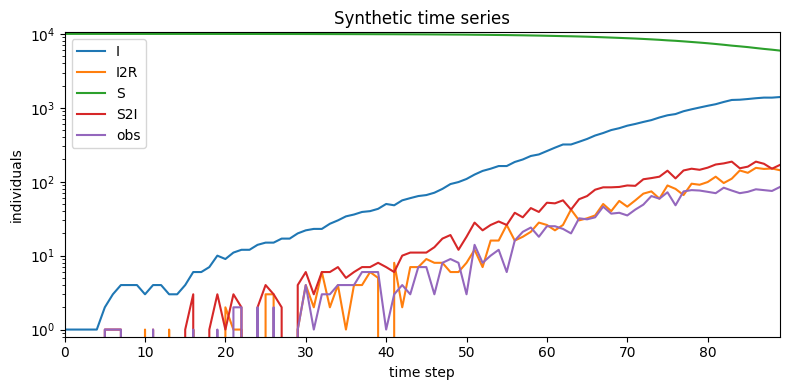

In [5]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

### Inference  <a class="anchor" id="Inference"></a>

Next let's recover estimates of the latent variables given only observations `obs`. To do this we'll create a new model instance from the synthetic observations.

In [6]:
obs = synth_data["obs"]
model = SimpleSIRModel(population, recovery_time, obs)

The `CompartmentalModel` provides a number of inference algorithms. The cheapest and most scalable algorithm is SVI, avilable via the `.fit_svi()` method. This method returns a list of losses to help us diagnose convergence; the fitted parameters are stored in the model object.

In [7]:
%%time
losses = model.fit_svi(num_steps=101 if smoke_test else 2001,
                       jit=True)

INFO 	 Heuristic init: R0=1.83, rho=0.546
INFO 	 Running inference...
INFO 	 step 0 loss = 6.808
INFO 	 step 200 loss = 9.099
INFO 	 step 400 loss = 7.384
INFO 	 step 600 loss = 4.401
INFO 	 step 800 loss = 3.428
INFO 	 step 1000 loss = 3.242
INFO 	 step 1200 loss = 3.13
INFO 	 step 1400 loss = 3.016
INFO 	 step 1600 loss = 3.029
INFO 	 step 1800 loss = 3.05
INFO 	 step 2000 loss = 3.017
INFO 	 SVI took 12.7 seconds, 157.9 step/sec


CPU times: user 12.8 s, sys: 278 ms, total: 13.1 s
Wall time: 13.2 s


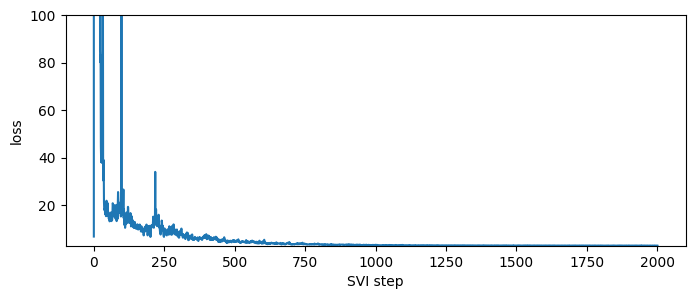

In [8]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("loss")
plt.ylim(min(losses), max(losses[50:]));

After inference, samples of latent variables are stored in the `.samples` attribute. These are primarily for internal use, and do not contain the full set of latent variables.

In [9]:
for key, value in sorted(model.samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

R0.shape = (100, 1)
auxiliary.shape = (100, 1, 2, 90)
rho.shape = (100, 1)


### Prediction  <a class="anchor" id="Prediction"></a>

After inference we can both examine latent variables and forecast forward using the [.predict()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.predict) method. First let's simply predict latent variables.

In [10]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 90 time steps...


CPU times: user 113 ms, sys: 2.82 ms, total: 116 ms
Wall time: 115 ms


In [11]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

I.shape = (100, 90)
I2R.shape = (100, 90)
R0.shape = (100, 1)
S.shape = (100, 90)
S2I.shape = (100, 90)
auxiliary.shape = (100, 1, 2, 90)
obs.shape = (100, 90)
rho.shape = (100, 1)


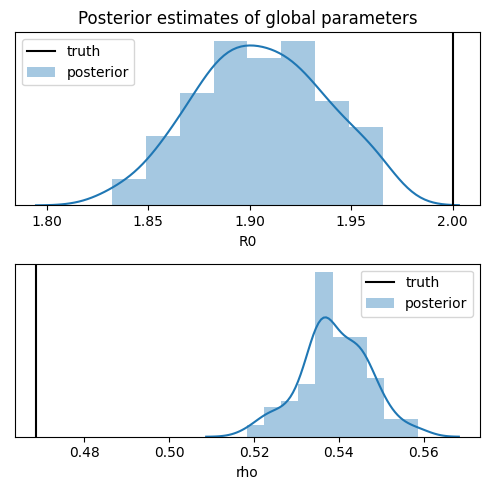

In [12]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()

Notice that while the inference recovers the basic reproductive number `R0`, it poorly estimates the response rate `rho` and underestimates its uncertainty. While perfect inference would provide better uncertainty estimates, the response rate is known to be difficult to recover from data. Ideally the model can either incorporate a narrower prior, either obtained by testing a random sample of the population, or by more accurate observations, e.g. counting deaths rather than confirmed infections.

### Forecasting  <a class="anchor" id="Forecasting"></a>

We can forecast forward by passing a `forecast` argument to the `.predict()` method, specifying the number of time steps ahead we'd like to forecast. The returned `sample` will contain time values during both the first observed time interval (here 90 days) and the forecasted window (say 30 days).

In [13]:
%time
samples = model.predict(forecast=30)

INFO 	 Predicting latent variables for 90 time steps...
INFO 	 Forecasting 30 steps ahead...


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


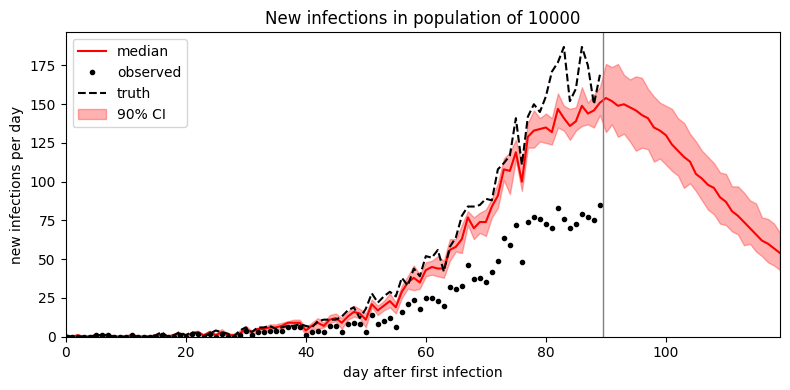

In [14]:
def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2I"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)

It looks like the mean field guide underestimates uncertainty. To improve uncertainty estimates we can instead try MCMC inference. In this simple model MCMC is only a small factor slower than SVI; in more complex models MCMC can be multiple orders of magnitude slower than SVI.

In [15]:
%%time
model = SimpleSIRModel(population, recovery_time, obs)
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 400,
                      jit_compile=True)

INFO 	 Running inference...
Sample: 100%|██████████| 800/800 [01:44,  7.63it/s, step size=1.07e-01, acc. prob=0.890]

CPU times: user 1min 43s, sys: 1.2 s, total: 1min 44s
Wall time: 1min 44s


INFO 	 Predicting latent variables for 90 time steps...
INFO 	 Forecasting 30 steps ahead...


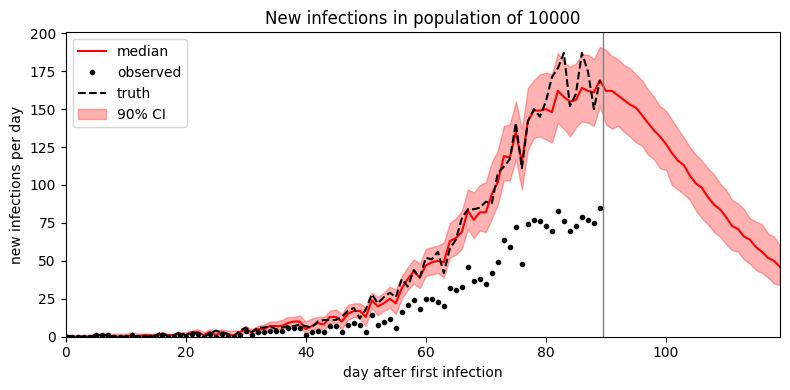

In [16]:
samples = model.predict(forecast=30)
plot_forecast(samples)

## Advanced modeling <a class="anchor" id="Advanced-modeling"></a>

So far we've seen how to create a simple univariate model, fit the model to data, and predict and forecast future data. Next let's consider more advanced modeling techniques:

- [regional models](#Regional-models) that couple compartments among multiple aggregated regions;
- [phylogenetic likelihoods](#Phylogenetic-likelihoods) to incorporate genetic sequencing data;
- [heterogeneous models](#Heterogeneous-models) with time-varying latent variables; and
- [Complex compartment flow](#Complex-compartment-flow) for models with non-linear transitions.

### Regional models  <a class="anchor" id="Regional-models"></a>

Epidemiology models vary in their level of detail. At the coarse-grained extreme are univariate aggregate models as we saw above. At the fine-grained extreme are network models where each individual's state is tracked and infections occur along edges of a sparse graph (`pyro.contrib.epidemiology` does not implement network models). We now consider an mid-level model where each of many regions (e.g. countries or zip codes) is tracked in aggregate, and infections occur both within regions and between pairs of regions. In Pyro we model multiple regions with a [plate](http://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.plate). Pyro's [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) class does not support general `pyro.plate` syntax, but it does support a single special `self.region_plate` for regional models. This plate is available iff a `CompartmentalModel` is initialized with a vector `population`, and the size of the `region_plate` will be the length of the `population` vector.

Let's take a look at the example [RegionalSIRModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.models.RegionalSIRModel):

In [17]:
class RegionalSIRModel(CompartmentalModel):
    def __init__(self, population, coupling, recovery_time, data):
        duration = len(data)
        num_regions, = population.shape
        assert coupling.shape == (num_regions, num_regions)
        assert (0 <= coupling).all()
        assert (coupling <= 1).all()
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        if isinstance(data, torch.Tensor):
            # Data tensors should be oriented as (time, region).
            assert data.shape == (duration, num_regions)
        compartments = ("S", "I")  # R is implicit.

        # We create a regional model by passing a vector of populations.
        super().__init__(compartments, duration, population, approximate=("I",))

        self.coupling = coupling
        self.recovery_time = recovery_time
        self.data = data

    def global_model(self):
        # Assume recovery time is a known constant.
        tau = self.recovery_time

        # Assume reproductive number is unknown but homogeneous.
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))

        # Assume response rate is heterogeneous and model it with a
        # hierarchical Gamma-Beta prior.
        rho_c1 = pyro.sample("rho_c1", dist.Gamma(10, 1))
        rho_c0 = pyro.sample("rho_c0", dist.Gamma(10, 1))
        with self.region_plate:
            rho = pyro.sample("rho", dist.Beta(rho_c1, rho_c0))

        return R0, tau, rho

    def initialize(self, params):
        # Start with a single infection in region 0.
        I = torch.zeros_like(self.population)
        I[0] += 1
        S = self.population - I
        return {"S": S, "I": I}

    def transition(self, params, state, t):
        R0, tau, rho = params

        # Account for infections from all regions. This uses approximate (point
        # estimate) counts I_approx for infection from other regions, but uses
        # the exact (enumerated) count I for infections from one's own region.
        I_coupled = state["I_approx"] @ self.coupling
        I_coupled = I_coupled + (state["I"] - state["I_approx"]) * self.coupling.diag()
        I_coupled = I_coupled.clamp(min=0)  # In case I_approx is negative.
        pop_coupled = self.population @ self.coupling

        with self.region_plate:
            # Sample flows between compartments.
            S2I = pyro.sample("S2I_{}".format(t),
                              infection_dist(individual_rate=R0 / tau,
                                             num_susceptible=state["S"],
                                             num_infectious=I_coupled,
                                             population=pop_coupled))
            I2R = pyro.sample("I2R_{}".format(t),
                              binomial_dist(state["I"], 1 / tau))

            # Update compartments with flows.
            state["S"] = state["S"] - S2I
            state["I"] = state["I"] + S2I - I2R

            # Condition on observations.
            t_is_observed = isinstance(t, slice) or t < self.duration
            pyro.sample("obs_{}".format(t),
                        binomial_dist(S2I, rho),
                        obs=self.data[t] if t_is_observed else None)

The main differences from the earlier univariate model are that: we assume `population` is a vector of length `num_regions`, we sample all compartmental variables and some global variables inside the `region_plate`, and we compute coupled vectors `I_coupled` and `pop_coupled` of the effective number of infected individuals and population accounting for both intra-region and inter-region infections. Among global variables we have chosen for demonstration purposes to make `tau` a fixed single number, `R0` a single latent variable shared among all regions, and `rho` a local latent variable that can take a different value for each region. Note that while `rho` is not shared among regions, we have created a hierarchical model whereby `rho`'s parent variables are shared among regions. While some of our variables are region-global and some region-local, only the compartmental variables are both region-local and time-dependent; all other parameters are fixed for all time. See the [heterogeneous models](#Heterogeneous-models) section below for time-dependent latent variables.

Note that Pyro's enumerated MCMC strategy (`.fit_mcmc()` with `num_quant_bins > 1`) requires extra logic to use a mean-field approximation across compartments: we pass `approximate=("I",)` to the constructor and force compartements to iteract via `state["I_approx"]` rather than `state["I"]`. This code is not required for SVI inference or for moment-matched MCMC inference (`.fit_mcmc()` with the default `num_quant_bins=0`).

See the [Epidemiology: regional models](http://pyro.ai/examples/epi_regional.html) example for a demonstration of how to generate data, train, predict, and forecast with regional models. 

### Phylogenetic likelihoods  <a class="anchor" id="Phylogenetic-likelihoods"></a>

Epidemiological parameters can be difficult to identify from aggregate observations alone. However some parameters like the superspreading parameter `k` can be more accurately identified by combining aggregate count data with viral phylogenetic trees reconstructed from viral genetic sequencing data [(Li et al. 2017)](#1). Pyro implements a [CoalescentRateLikelihood](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.distributions.CoalescentRateLikelihood) class to compute a population likelihood `p(I|phylogeny)` given statistics of a phylogenetic tree (or a batch of tree samples). The statistics needed are exactly the times of each sampling event (i.e. when a viral genome was sequenced) and the times of genetic coalescent events in a binary phylogenetic tree; let us call these two vectors ``leaf_times`` and ``coal_times``, respectively, where ``len(leaf_times) == 1 + len(coal_times)`` for binary trees. Pyro provides a helper [bio_phylo_to_times()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.distributions.coalescent.bio_phylo_to_times) to extract these statistics from a [Bio.Phylo tree objects](https://biopython.readthedocs.io/en/latest/api/Bio.Phylo.BaseTree.html#Bio.Phylo.BaseTree.Clade); in turn [Bio.Phylo](https://biopython-tutorial.readthedocs.io/en/latest/notebooks/13%20-%20Phylogenetics%20with%20Bio.Phylo.html) can parse many file formats of phylogenetic trees.

Let's take a look at the [SuperspreadingSEIRModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.models.SuperspreadingSEIRModel) which includes a phylogenetic likelihood. We'll focus on the phylogenetic parts of the model:

```python
class SuperspreadingSEIRModel(CompartmentalModel):
    def __init__(self, population, incubation_time, recovery_time, data, *,
                 leaf_times=None, coal_times=None):
        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        ...
        self.coal_likelihood = dist.CoalescentRateLikelihood(
            leaf_times, coal_times, duration)
    ...
    
    def transition(self, params, state, t):
        ...
        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        R = R0 * state["S"] / self.population
        coal_rate = R * (1. + 1. / k) / (tau_i * state["I"] + 1e-8)
        pyro.factor("coalescent_{}".format(t),
                    self.coal_likelihood(coal_rate, t)
                    if t_is_observed else torch.tensor(0.))
```
We first constructed a ``CoalescentRateLikelihood`` object to be used throughout inference and prediction; this performs preprocessing work once so that it is cheap to evaluate ``self.coal_likelihood(...)``. Note that ``(leaf_times, coal_times)`` should be in units of time steps, the same time steps as the time index `t` and `duration`. Typically ``leaf_times`` are in ``[0, duration)``, but ``coal_times`` precede ``leaf_times`` (as points of common ancestry), and may be negative. The likelihood involves the coalescent rate ``coal_rate`` in a coalescent process; we can compute this from an epidemiological model. In this superspreading model ``coal_rate`` depends on the reproductive number ``R``, the superspreading parameter ``k``, the incubation time ``tau_i``, and the current number of infected individuals ``state["I"]`` [(Li et al. 2017)](#1).

### Heterogeneous models  <a class="anchor" id="Heterogeneous-models"></a>

Epidemiological parameters often vary in time, due to human interventions, changes in weather, and other external factors. We can model real-valued time-varying latent variables in ``CompartmentalModel`` by moving static latent variables from ``.global_model()`` to ``.initialize()`` and ``.transition()``. For example we can model a reproductive number under Brownian drift in log-space by initializing at a random ``R0`` and multiplying by a drifting factor, as in the [HeterogeneousSIRModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.models.HeterogeneousSIRModel) example:
```python
class HeterogeneousSIRModel(CompartmentalModel):
    ...
    def global_model(self):
        tau = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = ...
        return R0, tau, rho

    def initialize(self, params):
        # Start with a single infection.
        # We also store the initial beta value in the state dict.
        return {"S": self.population - 1, "I": 1, "beta": torch.tensor(1.)}

    def transition(self, params, state, t):
        R0, tau, rho = params
        # Sample heterogeneous variables.
        # This assumes beta slowly drifts via Brownian motion in log space.
        beta = pyro.sample("beta_{}".format(t),
                           dist.LogNormal(state["beta"].log(), 0.1))
        Rt = pyro.deterministic("Rt_{}".format(t), R0 * beta)

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=Rt / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        ...
        # Update compartments and heterogeneous variables.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R
        state["beta"] = beta  # We store the latest beta value in the state dict.
        ...
```
Here we deterministically initialize a scale factor ``beta = 1`` in ``.initialize()`` then let it drift via log-Brownian motion. We also need to update ``state["beta"]`` just as we update the compartmental variables. Now ``beta`` will be provided as a time series when we ``.predict()``. While we could have written ``Rt = R0 * beta``, we instead wrapped this computation in a ``pyro.deterministic`` thereby exposing ``Rt`` as another time series provided by ``.predict()``. Note that we could have instead sampled ``R0`` in ``.initialize()`` and let ``Rt`` drift directly, rather than introducing a scale factor ``beta``. However separating the two into a non-centered form improves geometry [(Betancourt and Girolami 2013)](#2).

It is also easy to pass in time-varying covariates as tensors, in the same way we have passed in ``data`` to the constructors of all example models. To predict the effects of different causal interventions, you can pass in a covariate that is longer than ``duration``, run inference (looking only at the first ``[0,duration)`` entries), then mutate entries of the covariate after ``duration`` and generate different ``.predict()``ions.

### Complex compartment flow  <a class="anchor" id="Complex-compartment-flow"></a>

The [CompartmentalModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel) class assumes by default that the compartments are arranged linearly and terminate in an implicit terminal compartment named "R", for example S-I-R, S-E-I-R or boxcar models like S-E1-E2-I1-I2-I3-R. To describe other more complex flows between compartments, you can override the [.compute_flows()](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.compartmental.CompartmentalModel.compute_flows) method. However currently there is no support for flows with undirected loops (e.g. S-I-S).

Let's create a branching SIRD model with possible flows
```
S → I → R
      ↘
        D
```
As with other models, we'll keep the "R" state implicit (although we could equally keep the "D" state implicit and the "R" state explicit). In the ``.compute_flows()`` method, we'll input a pair of states and we'll need to compute three flow values: ``S2I``, ``I2R``, and ``I2D``.
```python
class SIRDModel(CompartmentalModel):
    def __init__(self, population, data):
        compartments = ("S", "I", "D")
        duration = len(data)
        super().__init__(compartments, duration, population)
        self.data = data

    def compute_flows(self, prev, curr, t):
        S2I = prev["S"] - curr["S"]  # S can only go in one direction.
        I2D = curr["D"] - prev["D"]  # D can only have come from one direction.
        # Now by conservation at I, change + inflows + outflows = 0,
        # so we can solve for the single unknown I2R.
        I2R = prev["I"] - curr["I"] + S2I - I2D
        return {
            "S2I_{}".format(t): S2I,
            "I2D_{}".format(t): I2D,
            "I2R_{}".format(t): I2R,
        }
    ...
    def transition(self, params, state, t):
        ...
        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t), ...)
        I2D = pyro.sample("I2D_{}".format(t), ...)
        I2R = pyro.sample("I2R_{}".format(t), ...)

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2D - I2R
        state["D"] = state["D"] + I2D
        ...
```
Note you can name the dict keys anything you want, as long as they match your sample statements in ``.transition()`` and you correctly reverse the flow computation in ``.transition()``. During inference Pyro will check that the ``.compute_flows()`` and ``.transition()`` computations agree. Take care to avoid in-place PyTorch operations, since these can modify the tensors rather than the dictionary:
```diff
+ state["S"] = state["S"] - S2I  # Correct
- state["S"] -= S2I              # AVOID: may corrupt tensors
```

For a slightly more complex example, take a look at the [SimpleSEIRDModel](http://docs.pyro.ai/en/latest/contrib.epidemiology.html#pyro.contrib.epidemiology.models.SimpleSEIRDModel).

## References

1.  <a class="anchor" id="1"></a>
    Lucy M. Li, Nicholas C. Grassly, Christophe Fraser (2017)
    "Quantifying Transmission Heterogeneity Using Both Pathogen Phylogenies
    and Incidence Time Series"
    https://academic.oup.com/mbe/article/34/11/2982/3952784
2.  <a class="anchor" id="2"></a>
    M. J. Betancourt, Mark Girolami (2013)
    "Hamiltonian Monte Carlo for Hierarchical Models"
    https://arxiv.org/abs/1312.0906